# Imports

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.feature_extraction
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

from IPython.display import display, clear_output

import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Cross Validation sets

In [ ]:
music = pd.read_csv('https://raw.githubusercontent.com/roody225/ML_MGR_datasets/master/music_features.csv')
lyrics = pd.read_csv('https://raw.githubusercontent.com/roody225/ML_MGR_datasets/master/texts.csv')

In [ ]:
test_id = np.array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
          290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
          490, 491, 492, 493, 494, 495, 496, 497, 498, 499])

def testGen(df):
    tmp = df.iloc[test_id]
    return tmp.drop(labels='label', axis=1), tmp['label']

def trainGen(df, id):
    df = df.drop(test_id)
    indices = np.array([])
    if id < 0:
        return df.drop(labels='label', axis=1), df['label']
    start = id * 10
    end = start + 10
    for i in range(5):
        cur = i * 100
        indices = np.append(indices, np.arange(cur+start, cur+end))
    tmp = df.drop(indices)
    return tmp.drop(labels='label', axis=1), tmp['label']
        
def validationGen(df, id):
    indices = np.array([])
    start = id * 10
    end = start + 10
    for i in range(5):
        cur = i * 100
        indices = np.append(indices, np.arange(cur+start, cur+end))
    tmp = df.iloc[indices]
    return tmp.drop(labels='label', axis=1), tmp['label']

# AUX section

In [ ]:
#remove punctuation
def remove_punct(text):
    return "".join([c for c in text if c not in string.punctuation])
    
#tokenize
def tokenize(text):
    return re.split('\W+', text)
    
#remove stopwords
list_of_stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokens):
    return [word for word in tokens if word not in list_of_stopwords]
    
#Lemmatizing
wn = nltk.WordNetLemmatizer()
def lemmatize(tokens):
    return [wn.lemmatize(word) for word in tokens]
    
#stemming
ps = nltk.PorterStemmer()
def stemming(tokens):
    return [ps.stem(word) for word in tokens]

#accuracy
def accuracy(preds, y):
    correct = (preds == y)
    return np.count_nonzero(correct) / len(correct)

#calculate accuracy given model and df
def calculateAccuracy(model, df):
    test_x, test_y = testGen(df)
    preds = model.predict(test_x)
    return accuracy(preds, test_y)

#calculate accuracy given model and test df_x,df_y, for each genre
def calculate_accuracy(predictions, test_y):
    return (predictions == test_y).mean()

def accuracy_count(model,df_x,df_y):
  print( "Total accuracy:", 
      calculate_accuracy(model.predict(df_x),df_y ))
  for gen in ['blues','rock','hiphop','reggae','country']:
    df_x_temp = df_x.loc[df_y == gen]
    df_y_temp = df_y.loc[df_y == gen]
    print( "Accuracy for ", gen, ": ", 
          calculate_accuracy(model.predict(df_x_temp),df_y_temp) )

#KNN + Naive Bayes

In [ ]:
def musicKNN(train_x, train_y):
    model = KNeighborsClassifier(n_neighbors=4)
    model.fit(train_x, train_y.values.ravel())
    return model

In [ ]:
def textNBC(train_x, train_y):
    model = MultinomialNB(alpha = 1.0)
    model.fit(train_x, train_y)
    return model

In [ ]:
def prepareMusicKNN(df):
    scaler = sklearn.preprocessing.StandardScaler()
    features = df.drop(labels = 'label',axis = 1).columns
    df_standarized = df
    df_standarized[features] = scaler.fit_transform(df[features])
    return df


In [ ]:
prepared_music = prepareMusicKNN(music)

train = prepared_music.drop(test_id)
train_x, train_y = train.drop(labels='label', axis=1), train[['label']]
test_x,test_y = testGen(prepared_music)
music_KNN = musicKNN(train_x, train_y)
accuracy_count(music_KNN, test_x, test_y)

Total accuracy: 0.74
Accuracy for  blues :  0.8
Accuracy for  rock :  0.8
Accuracy for  hiphop :  0.6
Accuracy for  reggae :  0.6
Accuracy for  country :  0.9


In [ ]:
def prepareTextNBC(data):
    def clean_text(text):
        text = remove_punct(text)
        text = tokenize(text.lower())
        text = remove_stopwords(text)
        text = lemmatize(text)
        #uncomment if needed
        #text = stemming(text)
        return text
    count_vect = sklearn.feature_extraction.text.CountVectorizer(analyzer=clean_text)
    counts = count_vect.fit_transform(data['text'])
    # counts = TfidfTransformer().fit_transform(counts)
    #print(count_vect.get_feature_names())
    arr_counts = counts.toarray()
    df = data[['label']]
    for i in range(len(count_vect.get_feature_names())):
        df[i] = pd.Series(arr_counts.T[i])
    return df


In [ ]:
prepared_lyrics = prepareTextNBC(lyrics)

train = prepared_lyrics.drop(test_id)
train_x, train_y = train.drop(labels='label', axis=1), train[['label']]
test_x,test_y = testGen(prepared_lyrics)
lyrics_NBC = textNBC(train_x, train_y)
accuracy_count(lyrics_NBC, test_x, test_y)

Total accuracy: 0.68
Accuracy for  blues :  0.6
Accuracy for  rock :  0.3
Accuracy for  hiphop :  0.9
Accuracy for  reggae :  0.9
Accuracy for  country :  0.7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
music_processed_knn = prepareMusicKNN(music)
lyrics_processed_nbc = prepareTextNBC(lyrics)

music_model_knn = music_KNN
lyrics_model_nbc = lyrics_NBC

# SVM

In [ ]:
def prepareTextSVM(data):
    #clean_text
    def clean_text(text):
        text = remove_punct(text)
        text = tokenize(text.lower())
        text = remove_stopwords(text)
        text = lemmatize(text)
        text = stemming(text)
        return text

    #create BoW
    count_vect = sklearn.feature_extraction.text.CountVectorizer(analyzer=clean_text)
    counts = count_vect.fit_transform(data['text'])
    counts = TfidfTransformer().fit_transform(counts)
    names = count_vect.get_feature_names()
    arr_counts = counts.toarray()

    lyrics = data[['label']]
    tmp = pd.DataFrame()
    tmp['$#clean_len#$'] = data['text'].apply(clean_text).apply(len)
    tmp['$#len#$'] = data['text'].apply(tokenize).apply(len)
    for i in range(len(names)):
        tmp[names[i]] = pd.Series(arr_counts.T[i])
    selector = SelectKBest(chi2, k=2000).fit(tmp, lyrics)
    cols = selector.get_support(indices=True)
    tmp = tmp.iloc[:,cols]
    scaler = preprocessing.StandardScaler().fit(tmp)
    tmp = scaler.transform(tmp)
    tmp = pd.DataFrame(tmp)
    tmp['label'] = data['label']
    return tmp

def prepareMusicSVM(data):
    x = data.drop(labels=['label'], axis=1)
    y = data['label']
    scaler = preprocessing.StandardScaler().fit(x)
    x = scaler.transform(x)
    x = pd.DataFrame(x)
    x['label'] = y
    return x

In [ ]:
def musicSVM(x, y):
    model = SVC(kernel='rbf')
    model.fit(x, y)
    return model

def textSVM(x, y):
    model = SVC(kernel='sigmoid')
    model.fit(x, y)
    return model

In [ ]:
music_processed_svm = prepareMusicSVM(music)
lyrics_processed_svm = prepareTextSVM(lyrics)

music_train_x_svm, music_train_y_svm = trainGen(music_processed_svm, -1)
lyrics_train_x_svm, lyrics_train_y_svm = trainGen(lyrics_processed_svm, -1)

music_model_svm = musicSVM(music_train_x_svm, music_train_y_svm)
lyrics_model_svm = textSVM(lyrics_train_x_svm, lyrics_train_y_svm)

In [ ]:
test_m_x,test_m_y = testGen(music_processed_svm)
accuracy_count(music_model_svm, test_m_x, test_m_y)

Total accuracy: 0.78
Accuracy for  blues :  0.8
Accuracy for  rock :  0.8
Accuracy for  hiphop :  0.7
Accuracy for  reggae :  0.6
Accuracy for  country :  1.0


In [ ]:
test_l_x,test_l_y = testGen(lyrics_processed_svm)
accuracy_count(lyrics_model_svm, test_l_x, test_l_y)

Total accuracy: 0.86
Accuracy for  blues :  0.8
Accuracy for  rock :  0.9
Accuracy for  hiphop :  0.9
Accuracy for  reggae :  0.9
Accuracy for  country :  0.8


# Random Forest

In [ ]:
def prepareTextRF(data):
      #clean_text
    def clean_text(text):
        text = remove_punct(text)
        text = tokenize(text.lower())
        text = remove_stopwords(text)
        text = lemmatize(text)
        text = stemming(text)
        return text

    #create BoW
    count_vect = sklearn.feature_extraction.text.CountVectorizer(analyzer=clean_text)
    counts = count_vect.fit_transform(data['text'])
    counts = TfidfTransformer().fit_transform(counts)
    names = count_vect.get_feature_names()
    arr_counts = counts.toarray()

    lyrics = data[['label']]
    tmp = pd.DataFrame()
    tmp['$#clean_len#$'] = data['text'].apply(clean_text).apply(len)
    tmp['$#len#$'] = data['text'].apply(tokenize).apply(len)
    for i in range(len(names)):
        tmp[names[i]] = pd.Series(arr_counts.T[i])
    selector = SelectKBest(chi2, k=3700).fit(tmp, lyrics)
    cols = selector.get_support(indices=True)
    tmp = tmp.iloc[:,cols]
    scaler = preprocessing.StandardScaler().fit(tmp)
    tmp = scaler.transform(tmp)
    tmp = pd.DataFrame(tmp)
    tmp['label'] = data['label']
    return tmp

def prepareMusicRF(data):
  return data

In [ ]:
def musicRF(df_data,df_target):
  rfc = ensemble.RandomForestClassifier(max_samples=0.9,n_estimators=200,max_features=30,criterion='entropy')
  rfc.fit(df_data,df_target)
  return rfc


def textRF(df_data,df_target):
  rfc = ensemble.RandomForestClassifier(max_samples=0.9,n_estimators=500,max_features=60)
  rfc.fit(df_data,df_target)
  return rfc


In [ ]:
music_processed_rf = prepareMusicRF(music)
lyrics_processed_rf = prepareTextRF(lyrics)


In [ ]:

train_music = music_processed_rf.drop(test_id)
train_music_x, train_music_y = train_music.drop(labels='label', axis=1), train_music[['label']]

music_model_rf = musicRF(train_music_x, train_music_y)

train_lyrics = lyrics_processed_rf.drop(test_id)
train_lyrics_x, train_lyrics_y = train_lyrics.drop(labels='label', axis=1), train_lyrics[['label']]

lyrics_model_rf = textRF(train_lyrics_x, train_lyrics_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [ ]:
test_m_x,test_m_y = testGen(music_processed_rf)
accuracy_count(music_model_rf,test_m_x,test_m_y)

Total accuracy: 0.76
Accuracy for  blues :  0.9
Accuracy for  rock :  0.7
Accuracy for  hiphop :  0.8
Accuracy for  reggae :  0.6
Accuracy for  country :  0.8


In [ ]:
test_l_x,test_l_y = testGen(lyrics_processed_rf)
accuracy_count(lyrics_model_rf,test_l_x,test_l_y)

Total accuracy: 0.72
Accuracy for  blues :  0.7
Accuracy for  rock :  0.4
Accuracy for  hiphop :  0.9
Accuracy for  reggae :  0.9
Accuracy for  country :  0.7


#Accuracy comparison

In [ ]:
def accuracy_count(model,df_x,df_y):
  print( "Total accuracy:", 
      calculate_accuracy(model.predict(df_x),df_y ))
  for gen in ['blues','rock','hiphop','reggae','country']:
    df_x_temp = df_x.loc[df_y == gen]
    df_y_temp = df_y.loc[df_y == gen]
    print( "Accuracy for ", gen, ": ", 
          calculate_accuracy(model.predict(df_x_temp),df_y_temp) )
    
def genre_accuracies_for_model(model, df):
    df_x, df_y = testGen(df)
    accuracies = {}
    accuracies['total'] = sklearn.metrics.accuracy_score(df_y, model.predict(df_x))
    for gen in ['blues','rock','hiphop','reggae','country']:
        df_x_gen = df_x.loc[df_y == gen]
        df_y_gen = df_y.loc[df_y == gen]
        accuracies[gen] = sklearn.metrics.accuracy_score(df_y_gen, model.predict(df_x_gen))
    return accuracies

genre_accuracies_music = []
model_labels_music = ['KNN', 'SVM', 'RF']
genre_accuracies_lyrics = []
model_labels_lyrics = ['NBC', 'SVM', 'RF']
genre_accuracies_music.append(genre_accuracies_for_model(music_model_knn,  music_processed_knn))
genre_accuracies_lyrics.append(genre_accuracies_for_model(lyrics_model_nbc,  lyrics_processed_nbc))

genre_accuracies_music.append(genre_accuracies_for_model(music_model_svm,  music_processed_svm))
genre_accuracies_lyrics.append(genre_accuracies_for_model(lyrics_model_svm,  lyrics_processed_svm))

genre_accuracies_music.append(genre_accuracies_for_model(music_model_rf,  music_processed_rf))
genre_accuracies_lyrics.append(genre_accuracies_for_model(lyrics_model_rf,  lyrics_processed_rf))

In [ ]:
genre_acc_music_df = pd.DataFrame(genre_accuracies_music, index=model_labels_music)
genre_acc_lyrics_df = pd.DataFrame(genre_accuracies_lyrics, index=model_labels_lyrics)



Music

In [ ]:
genre_acc_music_df

,total,blues,rock,hiphop,reggae,country
KNN,0.74,0.8,0.8,0.6,0.6,0.9
SVM,0.78,0.8,0.8,0.7,0.6,1.0
RF,0.76,0.9,0.7,0.8,0.6,0.8


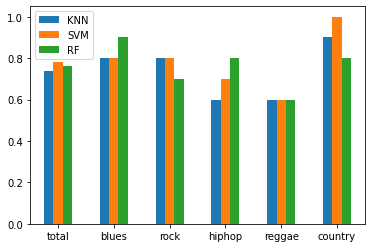

In [ ]:
genre_acc_music_df.T.plot.bar(rot = 0)

Lyrics


In [ ]:
genre_acc_lyrics_df

,total,blues,rock,hiphop,reggae,country
NBC,0.68,0.6,0.3,0.9,0.9,0.7
SVM,0.86,0.8,0.9,0.9,0.9,0.8
RF,0.72,0.7,0.4,0.9,0.9,0.7


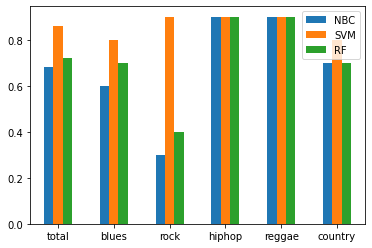

In [ ]:
genre_acc_lyrics_df.T.plot.bar(rot = 0)

#Genre Similarities


In [ ]:
genres = ['blues','rock','hiphop','reggae','country']
miss_ls = [np.zeros(len(genres)) for g in genres]
#print(miss_ls)

def missclassify_list(predictions, test_y):
    return list(predictions[predictions != test_y])

def genre_missclassify(model,df_x,df_y,miss_ls):
  for i in range(len(genres)):
    gen = genres[i]
    df_x_temp = df_x.loc[df_y == gen]
    df_y_temp = df_y.loc[df_y == gen]
    ml = missclassify_list(model.predict(df_x_temp),df_y_temp)
    for m in ml:
      miss_ls[i][genres.index(m)] += 1
  return miss_ls

def miss_plot(miss_ls,title):
  #print(miss_dict)
  n = len(genres)
  fig, axs = plt.subplots(2, 3,figsize=(15,10),sharey=True)
  ind = np.arange(n)
  fig.suptitle(title, fontsize=16)
  for i in range(n):
    ax = axs[i//3][i%3]
    ax.bar(ind,miss_ls[i])
    ax.set(ylabel='Missclassified '+genres[i])
    ax.set_xticklabels(np.concatenate(([0],genres))) 

def split_dataset(df,train_size):
  n = df.shape[0]
  perm = np.random.permutation(np.arange(n))
  trn_perm = perm[:int(n*train_size)]
  tst_perm = perm[int(n*train_size):]

  return df.iloc[list(trn_perm)].reset_index(drop=True),df.iloc[list(tst_perm)].reset_index(drop=True)

def crossValidationMiss(model, df, n):
  res = False
  acc = -1
  miss_ls = [np.zeros(len(genres)) for g in genres]
  #print(miss_dict)
  for i in range(n):
    # valid,train = split_dataset(df,0.1)
    # train_x, train_y = data_target(train)
    # valid_x,  valid_y = data_target(valid)
    train_x, train_y = trainGen(df, i)
    valid_x,  valid_y = validationGen(df, i)
    tmp = model(train_x, train_y)
    miss_ls = genre_missclassify(tmp,valid_x,valid_y,miss_ls)
  for i in range(len(genres)):
    for j in range(len(genres)):
      miss_ls[i][j] /= n
  return miss_ls
        

In [ ]:
miss_ls = crossValidationMiss(musicRF,music_processed_rf,9)

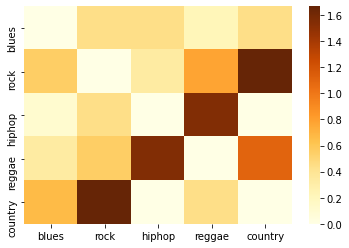

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

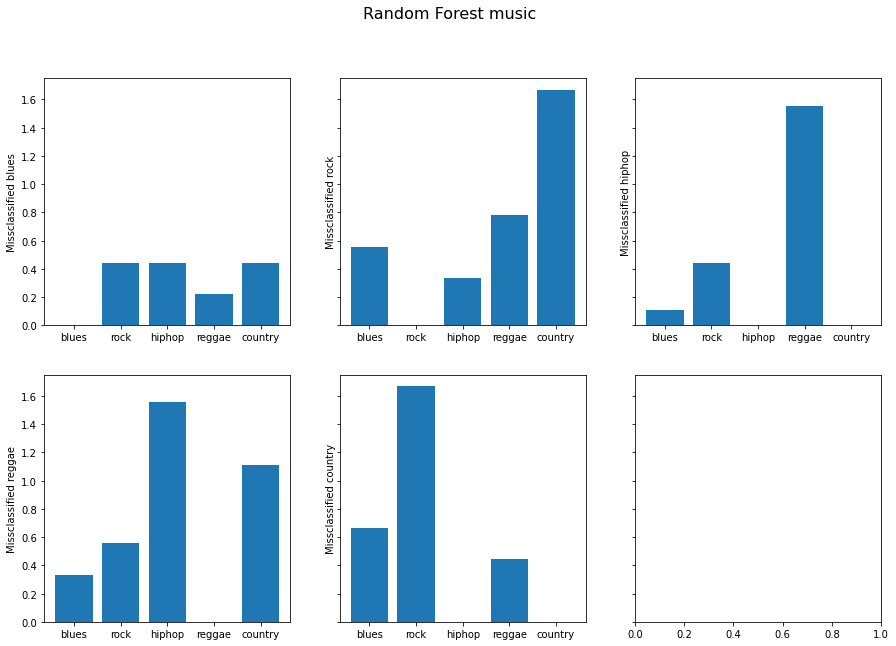

In [ ]:
miss_plot(miss_ls,"Random Forest music")

In [ ]:
miss_ls = crossValidationMiss(musicSVM,music_processed_svm,9)

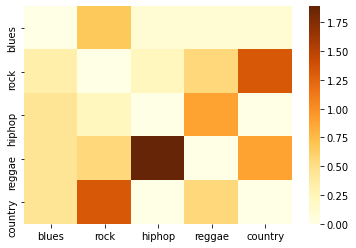

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

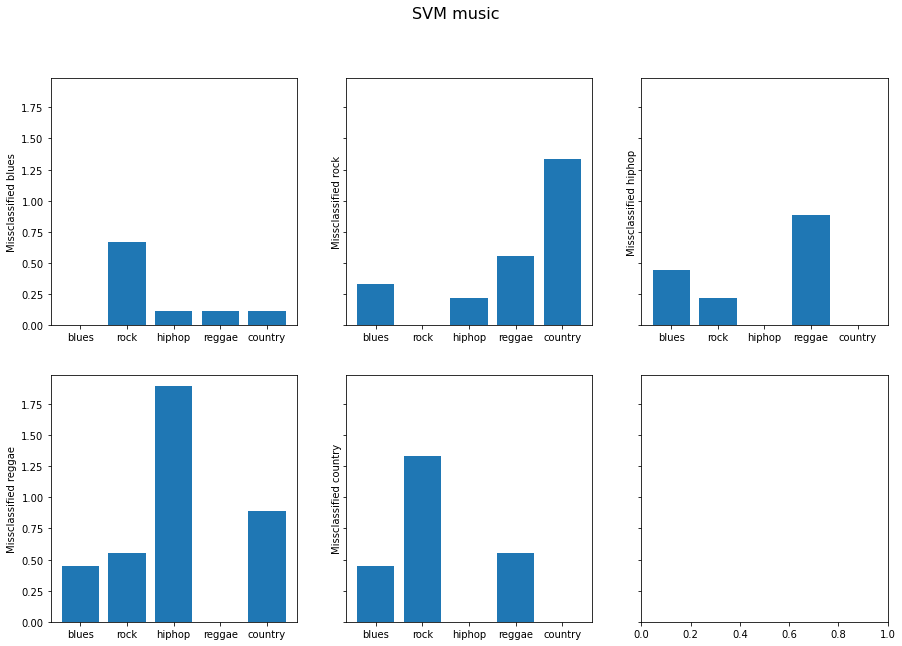

In [ ]:
miss_plot(miss_ls,"SVM music")

In [ ]:
miss_ls = crossValidationMiss(musicKNN,music_processed_knn,9)

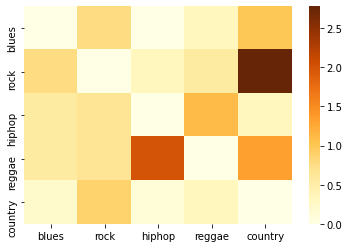

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

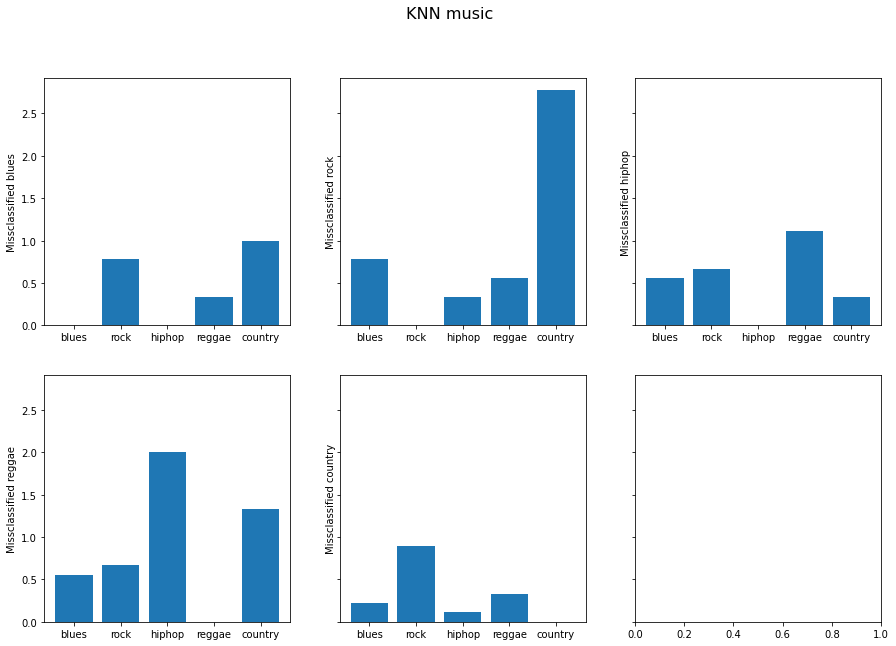

In [ ]:
miss_plot(miss_ls,"KNN music")

In [ ]:
miss_ls = crossValidationMiss(textRF,lyrics_processed_rf,9)

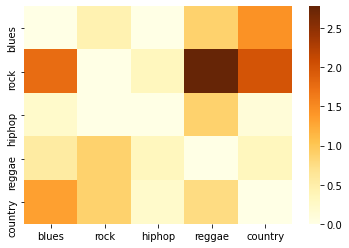

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

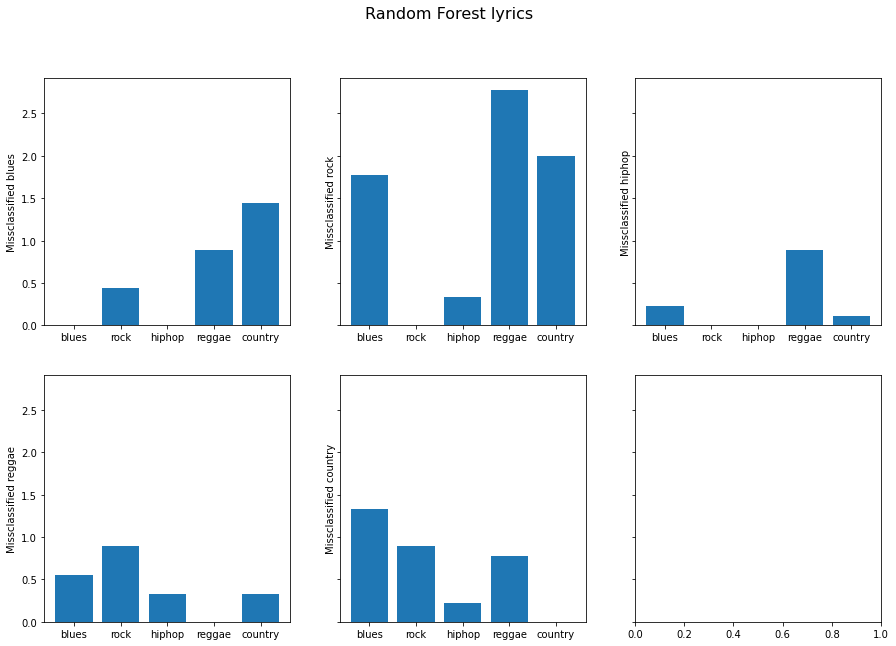

In [ ]:
miss_plot(miss_ls,"Random Forest lyrics")

In [ ]:
miss_ls = crossValidationMiss(textSVM,lyrics_processed_svm,9)

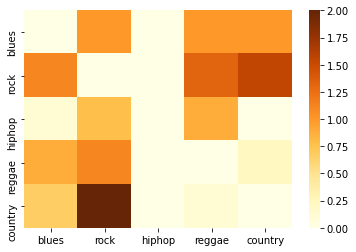

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

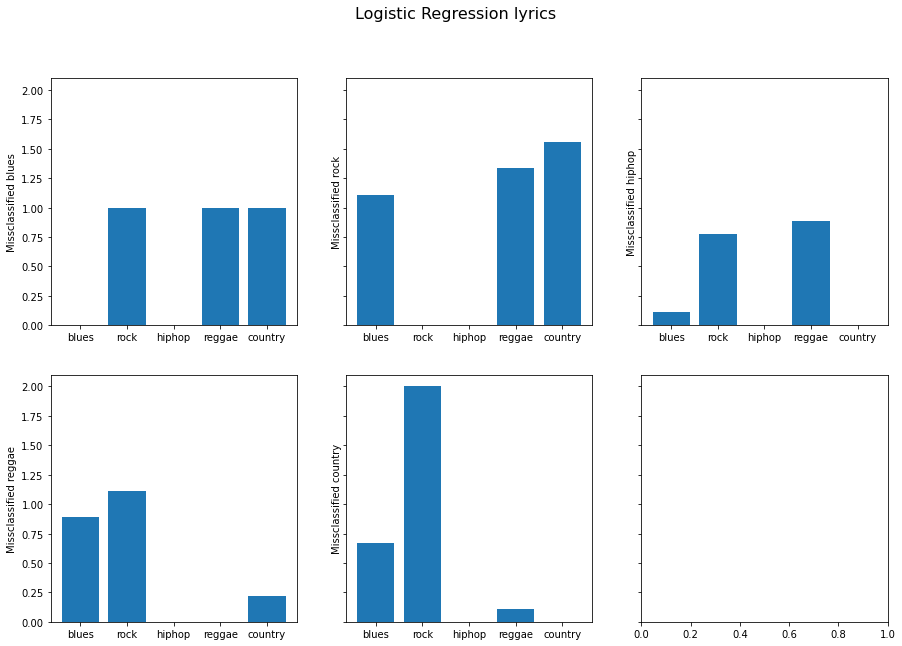

In [ ]:
miss_plot(miss_ls,"Logistic Regression lyrics")

In [ ]:
miss_ls = crossValidationMiss(textNBC,lyrics_processed_nbc,9)

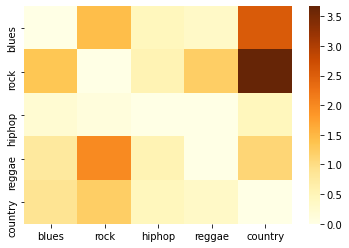

In [ ]:
sns.heatmap(miss_ls,xticklabels=genres,yticklabels=genres,cmap="YlOrBr")

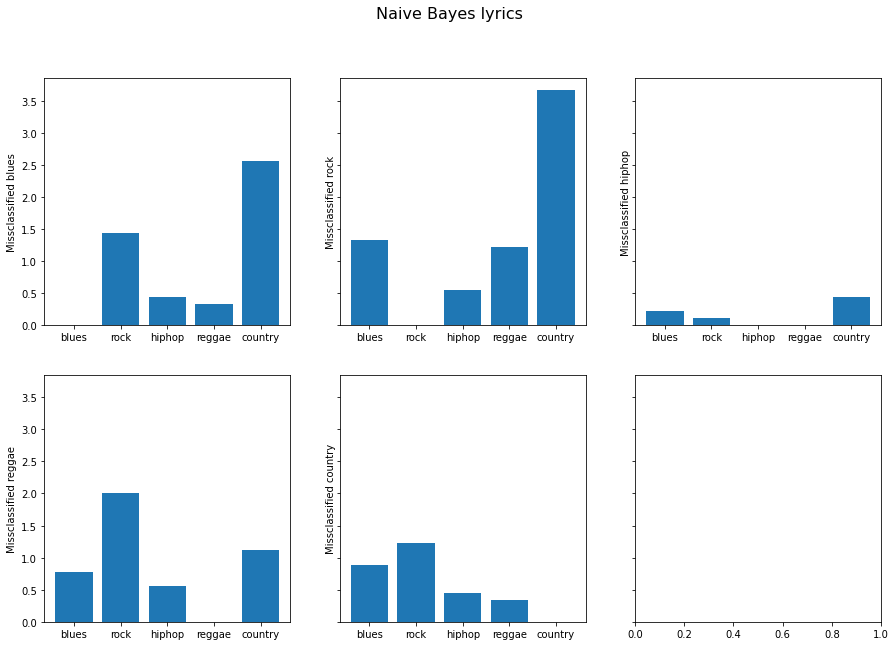

In [ ]:
miss_plot(miss_ls,"Naive Bayes lyrics")

In [ ]:
def missclassify_ids_list(predictions, test_y):
    n = len(test_y)
    nums = np.arange(0,n)
    return list(nums[predictions != test_y])

def genre_missclassify_ids(model,df):
  df_x,df_y = testGen(df)
  miss_dict = {}
  for i in range(len(genres)):
    gen = genres[i]
    df_x_temp = df_x.loc[df_y == gen]
    df_y_temp = df_y.loc[df_y == gen]
    miss_dict[gen] = missclassify_ids_list(model.predict(df_x_temp),df_y_temp)
  return miss_dict


In [ ]:
genre_missclassify_ids(music_model_rf,music_processed_rf)

{'blues': [1],
 'country': [2, 6],
 'hiphop': [4, 7],
 'reggae': [1, 5, 6, 7],
 'rock': [2, 4, 6]}

In [ ]:
genre_missclassify_ids(music_model_knn,music_processed_knn)

{'blues': [1, 6],
 'country': [0],
 'hiphop': [1, 3, 4, 9],
 'reggae': [0, 5, 7, 8],
 'rock': [2, 6]}

In [ ]:
genre_missclassify_ids(music_model_svm,music_processed_svm)

{'blues': [1, 3],
 'country': [],
 'hiphop': [2, 4, 5],
 'reggae': [0, 1, 5, 7],
 'rock': [2, 6]}

In [ ]:
genre_missclassify_ids(lyrics_model_rf,lyrics_processed_rf)

{'blues': [6, 7, 8],
 'country': [2, 8, 9],
 'hiphop': [5],
 'reggae': [5],
 'rock': [0, 3, 4, 5, 8, 9]}

In [ ]:
genre_missclassify_ids(lyrics_model_nbc,lyrics_processed_nbc)

{'blues': [3, 7, 8, 9],
 'country': [1, 2, 6],
 'hiphop': [4],
 'reggae': [3],
 'rock': [2, 3, 4, 5, 7, 8, 9]}

In [ ]:
genre_missclassify_ids(lyrics_model_svm,lyrics_processed_svm)

{'blues': [7, 8], 'country': [6, 9], 'hiphop': [1], 'reggae': [3], 'rock': [3]}